# Aggregate Productivity Shocks

In [1]:
from copy import deepcopy
from time import process_time

import matplotlib.pyplot as plt
import numpy as np

from HARK.ConsumptionSaving.ConsAggShockModel import (
    AggShockConsumerType,
    AggShockMarkovConsumerType,
    CobbDouglasEconomy,
    CobbDouglasMarkovEconomy,
)
from HARK.distributions import DiscreteDistribution
from HARK.utilities import plot_funcs


def mystr(number):
    return f"{number:.4f}"

In [2]:
# Solve an AggShockConsumerType's microeconomic problem
solve_agg_shocks_micro = False
# Solve for the equilibrium aggregate saving rule in a CobbDouglasEconomy
solve_agg_shocks_market = True
# Solve an AggShockMarkovConsumerType's microeconomic problem
solve_markov_micro = False
# Solve for the equilibrium aggregate saving rule in a CobbDouglasMarkovEconomy
solve_markov_market = False
# Solve a simple Krusell-Smith-style two state, two shock model
solve_krusell_smith = True
# Solve a CobbDouglasEconomy with many states, potentially utilizing the "state jumper"
solve_poly_state = False

### Example implementation of AggShockConsumerType

In [3]:
if solve_agg_shocks_micro or solve_agg_shocks_market:
    # Make an aggregate shocks consumer type
    AggShockExample = AggShockConsumerType()
    AggShockExample.cycles = 0

    # Make a Cobb-Douglas economy for the agents
    EconomyExample = CobbDouglasEconomy(agents=[AggShockExample])
    EconomyExample.make_AggShkHist()  # Simulate a history of aggregate shocks

    # Have the consumers inherit relevant objects from the economy
    AggShockExample.get_economy_data(EconomyExample)

In [4]:
if solve_agg_shocks_micro:
    # Solve the microeconomic model for the aggregate shocks example type (and display results)
    t_start = process_time()
    AggShockExample.solve()
    t_end = process_time()
    print(
        "Solving an aggregate shocks consumer took "
        + mystr(t_end - t_start)
        + " seconds.",
    )
    print(
        "Consumption function at each aggregate market resources-to-labor ratio gridpoint:",
    )
    m_grid = np.linspace(0, 10, 200)
    AggShockExample.unpack("cFunc")
    for M in AggShockExample.Mgrid.tolist():
        mMin = AggShockExample.solution[0].mNrmMin(M)
        c_at_this_M = AggShockExample.cFunc[0](m_grid + mMin, M * np.ones_like(m_grid))
        plt.plot(m_grid + mMin, c_at_this_M)
    plt.ylim(0.0, None)
    plt.xlim(0.0, 10.0)
    plt.xlabel(r"Normalized market resources $m_t$")
    plt.ylabel(r"Normalized consumption $c_t$")
    plt.show()

In [5]:
if solve_agg_shocks_market:
    # Solve the "macroeconomic" model by searching for a "fixed point dynamic rule"
    t_start = process_time()
    print(
        "Now solving for the equilibrium of a Cobb-Douglas economy. This might take a few minutes...",
    )
    EconomyExample.solve()
    t_end = process_time()
    print(
        'Solving the "macroeconomic" aggregate shocks model took '
        + str(t_end - t_start)
        + " seconds.",
    )

Now solving for the equilibrium of a Cobb-Douglas economy. This might take a few minutes...
intercept=-0.3411752677185279, slope=1.1033122415919356, r-sq=0.9964206572838589
intercept=-0.49905471992188616, slope=1.1493932929247541, r-sq=0.9967900768430012
intercept=-0.4390471187773469, slope=1.1070163216831554, r-sq=0.9789390883667088
intercept=-0.374231502770288, slope=1.0806745382235008, r-sq=0.9872196971465007
intercept=-0.3526026204591546, slope=1.0721860841421091, r-sq=0.989850706812174
intercept=-0.343385235253611, slope=1.0686086369608845, r-sq=0.9902038507378159
intercept=-0.33940867583358597, slope=1.067077651140743, r-sq=0.9903328746358381
intercept=-0.33769614997412545, slope=1.0664224842852574, r-sq=0.9903853084121663
intercept=-0.3369623214506455, slope=1.0661431763472158, r-sq=0.990407270316121
intercept=-0.3366495314509357, slope=1.0660246320134479, r-sq=0.9904165453741468
intercept=-0.3365168813727766, slope=1.0659745404783012, r-sq=0.9904204634317887
intercept=-0.336460

Aggregate savings as a function of aggregate market resources:


C:\Users\Matthew\Documents\GitHub\HARK\HARK\ConsumptionSaving\ConsAggShockModel.py:3082: RuntimeWarning: divide by zero encountered in log
  Aagg = np.exp(self.intercept + self.slope * np.log(Mnow))


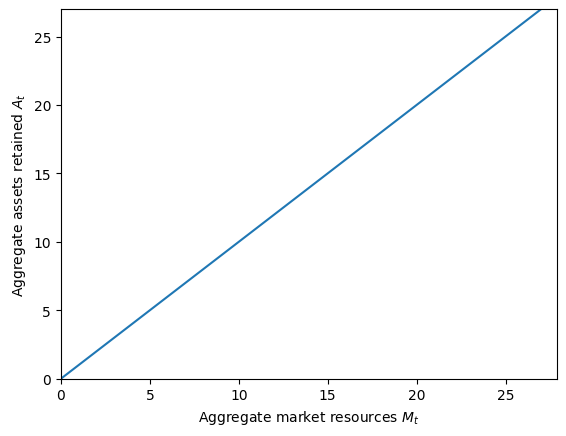

In [6]:
if solve_agg_shocks_market:
    print("Aggregate savings as a function of aggregate market resources:")
    plt.xlabel(r"Aggregate market resources $M_t$")
    plt.ylabel(r"Aggregate assets retained $A_t$")
    plt.ylim(0.0, 27.0)
    plot_funcs(EconomyExample.AFunc, 0, 2 * EconomyExample.kSS)

Consumption function at each aggregate market resources gridpoint (in general equilibrium):


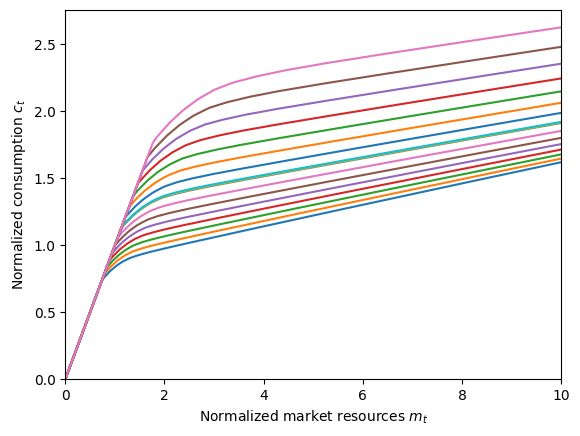

In [7]:
if solve_agg_shocks_market:
    print(
        "Consumption function at each aggregate market resources gridpoint (in general equilibrium):",
    )
    AggShockExample.unpack("cFunc")
    m_grid = np.linspace(0, 10, 200)
    for M in AggShockExample.Mgrid.tolist():
        mMin = AggShockExample.solution[0].mNrmMin(M)
        c_at_this_M = AggShockExample.cFunc[0](m_grid + mMin, M * np.ones_like(m_grid))
        plt.plot(m_grid + mMin, c_at_this_M)
    plt.ylim(0.0, None)
    plt.xlim(0.0, 10.0)
    plt.xlabel(r"Normalized market resources $m_t$")
    plt.ylabel(r"Normalized consumption $c_t$")
    plt.show()

### Example Implementations of AggShockMarkovConsumerType

In [8]:
if solve_markov_micro or solve_markov_market or solve_krusell_smith:
    # Make a Markov aggregate shocks consumer type
    AggShockMrkvExample = AggShockMarkovConsumerType()
    AggShockMrkvExample.IncShkDstn = [2 * [AggShockMrkvExample.IncShkDstn[0]]]
    AggShockMrkvExample.cycles = 0

    # Make a Cobb-Douglas economy for the agents
    MrkvEconomyExample = CobbDouglasMarkovEconomy(agents=[AggShockMrkvExample])
    MrkvEconomyExample.DampingFac = 0.2  # Turn down damping
    MrkvEconomyExample.make_AggShkHist()  # Simulate a history of aggregate shocks
    AggShockMrkvExample.get_economy_data(
        MrkvEconomyExample,
    )  # Have the consumers inherit relevant objects from the economy

In [9]:
if solve_markov_micro:
    # Solve the microeconomic model for the Markov aggregate shocks example type (and display results)
    t_start = process_time()
    AggShockMrkvExample.solve()
    t_end = process_time()
    print(
        "Solving an aggregate shocks Markov consumer took "
        + mystr(t_end - t_start)
        + " seconds.",
    )

    print(
        "Consumption function at each aggregate market \
            resources-to-labor ratio gridpoint (for each macro state):",
    )
    m_grid = np.linspace(0, 10, 200)
    AggShockMrkvExample.unpack("cFunc")
    for i in range(2):
        for M in AggShockMrkvExample.Mgrid.tolist():
            mMin = AggShockMrkvExample.solution[0].mNrmMin[i](M)
            c_at_this_M = AggShockMrkvExample.cFunc[0][i](
                m_grid + mMin,
                M * np.ones_like(m_grid),
            )
            plt.plot(m_grid + mMin, c_at_this_M)
        plt.ylim(0.0, None)
        plt.show()

In [10]:
if solve_markov_market:
    # Solve the "macroeconomic" model by searching for a "fixed point dynamic rule"
    t_start = process_time()
    print("Now solving a two-state Markov economy.  This should take a few minutes...")
    MrkvEconomyExample.solve()
    t_end = process_time()
    print(
        'Solving the "macroeconomic" aggregate shocks model took '
        + str(t_end - t_start)
        + " seconds.",
    )

    print(
        "Consumption function at each aggregate market \
            resources-to-labor ratio gridpoint (for each macro state):",
    )
    m_grid = np.linspace(0, 10, 200)
    AggShockMrkvExample.unpack("cFunc")
    for i in range(2):
        for M in AggShockMrkvExample.Mgrid.tolist():
            mMin = AggShockMrkvExample.solution[0].mNrmMin[i](M)
            c_at_this_M = AggShockMrkvExample.cFunc[0][i](
                m_grid + mMin,
                M * np.ones_like(m_grid),
            )
            plt.plot(m_grid + mMin, c_at_this_M)
        plt.ylim(0.0, None)
        plt.show()

In [11]:
if solve_krusell_smith:
    # Make a Krusell-Smith agent type
    # NOTE: These agents aren't exactly like KS, as they don't have serially correlated unemployment
    KSexampleType = deepcopy(AggShockMrkvExample)
    KSexampleType.IncShkDstn[0] = [
        DiscreteDistribution(
            np.array([0.96, 0.04]),
            np.array([[1.0, 1.0], [1.0 / 0.96, 0.0]]),
        ),
        DiscreteDistribution(
            np.array([0.90, 0.10]),
            np.array([[1.0, 1.0], [1.0 / 0.90, 0.0]]),
        ),
    ]

    # Make a KS economy
    KSeconomy = deepcopy(MrkvEconomyExample)
    KSeconomy.agents = [KSexampleType]
    KSeconomy.AggShkDstn = [
        DiscreteDistribution(
            np.array([1.0]),
            np.array([[1.0], [1.05]]),
        ),
        DiscreteDistribution(
            np.array([1.0]),
            np.array([[1.0], [0.95]]),
        ),
    ]
    KSeconomy.PermGroFacAgg = [1.0, 1.0]
    KSexampleType.get_economy_data(KSeconomy)
    KSeconomy.make_AggShkHist()

    # Solve the K-S model
    t_start = process_time()
    print(
        "Now solving a Krusell-Smith-style economy.  This should take about a minute...",
    )
    KSeconomy.solve()
    t_end = process_time()
    print("Solving the Krusell-Smith model took " + str(t_end - t_start) + " seconds.")

Now solving a Krusell-Smith-style economy.  This should take about a minute...
intercept=[-0.6061435639925716, -0.5765605983128899], slope=[1.1926141896468776, 1.1847304198503745], r-sq=[0.9981611138059812, 0.9979684015708614]
intercept=[-0.40379437456035727, -0.3996152051055967], slope=[1.0763373553693298, 1.078560328608425], r-sq=[0.9997743919958338, 0.9991142443444764]
intercept=[-0.35227531243507676, -0.3476318454321411], slope=[1.0687198439943442, 1.0684950234551973], r-sq=[0.9999988430503892, 0.9999967657081904]
intercept=[-0.3738838524669506, -0.36681805561603065], slope=[1.0769627348251782, 1.0757737479339557], r-sq=[0.9999979907790051, 0.9999932392637275]
intercept=[-0.3738953794038592, -0.36668111816534815], slope=[1.076979122193431, 1.075739027185397], r-sq=[0.9999979314952837, 0.9999930814997586]
intercept=[-0.3739505236889607, -0.3667216023381703], slope=[1.0769982408883878, 1.0757536841964626], r-sq=[0.9999979281671889, 0.9999930685145865]
Solving the Krusell-Smith model 

intercept=[-0.5817183825422839, -0.5703319414353534], slope=[1.180307914835392, 1.182408206717251], r-sq=[0.9975542198241366, 0.9980320884475001]


intercept=[-0.4180260563496857, -0.41316539564814475], slope=[1.08342735891103, 1.0852799171504508], r-sq=[0.99973377603989, 0.9993225507148125]


intercept=[-0.3600899736514895, -0.35512016452337497], slope=[1.0714753213364976, 1.0712256905434414], r-sq=[0.9999986714166439, 0.9999961301697309]


intercept=[-0.3788395320005977, -0.3715109817321105], slope=[1.0786573434429672, 1.0774887741894947], r-sq=[0.9999982037028008, 0.9999942754223826]


intercept=[-0.37896012954317376, -0.37156486819095047], slope=[1.0787111353569707, 1.0775241504232804], r-sq=[0.9999982049718272, 0.9999940788572959]


intercept=[-0.37899550407019866, -0.3715956660284524], slope=[1.0787232463104646, 1.0775357473879463], r-sq=[0.9999982037318698, 0.9999940713848707]
Solving the Krusell-Smith model took 41.253191999999984 seconds.


In [12]:
if solve_poly_state:
    StateCount = 15  # Number of Markov states
    GrowthAvg = 1.01  # Average permanent income growth factor
    GrowthWidth = 0.02  # PermGroFacAgg deviates from PermGroFacAgg in this range
    Persistence = 0.90  # Probability of staying in the same Markov state
    PermGroFacAgg = np.linspace(
        GrowthAvg - GrowthWidth,
        GrowthAvg + GrowthWidth,
        num=StateCount,
    )

    # Make the Markov array with chosen states and persistence
    PolyMrkvArray = np.zeros((StateCount, StateCount))
    for i in range(StateCount):
        for j in range(StateCount):
            if i == j:
                PolyMrkvArray[i, j] = Persistence
            elif (i == (j - 1)) or (i == (j + 1)):
                PolyMrkvArray[i, j] = 0.5 * (1.0 - Persistence)
    PolyMrkvArray[0, 0] += 0.5 * (1.0 - Persistence)
    PolyMrkvArray[StateCount - 1, StateCount - 1] += 0.5 * (1.0 - Persistence)

    # Make a consumer type to inhabit the economy
    PolyStateExample = AggShockMarkovConsumerType()
    PolyStateExample.MrkvArray = PolyMrkvArray
    PolyStateExample.PermGroFacAgg = PermGroFacAgg
    PolyStateExample.IncShkDstn[0] = StateCount * [PolyStateExample.IncShkDstn[0]]
    PolyStateExample.cycles = 0

    # Make a Cobb-Douglas economy for the agents
    # Use verbose=False to remove printing of intercept
    PolyStateEconomy = CobbDouglasMarkovEconomy(
        agents=[PolyStateExample],
        verbose=False,
    )
    PolyStateEconomy.MrkvArray = PolyMrkvArray
    PolyStateEconomy.PermGroFacAgg = PermGroFacAgg
    PolyStateEconomy.PermShkAggStd = StateCount * [0.006]
    PolyStateEconomy.TranShkAggStd = StateCount * [0.003]
    PolyStateEconomy.slope_prev = StateCount * [1.0]
    PolyStateEconomy.intercept_prev = StateCount * [0.0]
    PolyStateEconomy.update()
    PolyStateEconomy.makeAggShkDstn()
    PolyStateEconomy.make_AggShkHist()  # Simulate a history of aggregate shocks
    PolyStateExample.get_economy_data(
        PolyStateEconomy,
    )  # Have the consumers inherit relevant objects from the economy

    # Solve the many state model
    t_start = process_time()
    print(
        "Now solving an economy with "
        + str(StateCount)
        + " Markov states.  This might take a while...",
    )
    PolyStateEconomy.solve()
    t_end = process_time()
    print(
        "Solving a model with "
        + str(StateCount)
        + " states took "
        + str(t_end - t_start)
        + " seconds.",
    )